<a href="https://colab.research.google.com/github/ashutosh3060/friday-burger-mojito/blob/master/eda_model_build.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Table of Contents:

0. Libraries
1. User-Defined Functions
2. Import Data
3. Exploratory Data Analysis   
  3.1 Class Imbalance for Target variable   
  3.2 Bivariate Analysis
        3.2.1 Continuous variables
        3.2.2 Multi-category categorical variables
        3.2.2 Binary categorical variables
  3.3 Multi-variate Analysis
4. Data Preparation for Model Building
5. Model Build
6. Hyperparameter Tuning
7. Evaluation
8. Final Recommendation

## 0. Libraries

In [1]:
# warnings
import warnings
warnings.filterwarnings("ignore")

# Dataframe, numerical exp and other python-native libraries
import time
from collections import Counter
import pickle
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint

# sklearn
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split, cross_val_score, KFold, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score, confusion_matrix, classification_report, f1_score
# XGBoost
from xgboost import XGBClassifier, plot_importance

# imblearn for imbalanced data handling
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Display Settings
sns.set_style('whitegrid')
sns.set(font_scale=1.25)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 100)

## 1. User-Defined Functions

In [10]:
def bivar_contns(nonreturn_df, return_df, contns_col):
    '''
    Plots the continuous variable's histogram for the returning and non-returning customers

    Inputs
    ----------
    nonreturn_df : dataframe
        Dataframe containing Non-returning customers only
    return_df : dataframe
        Dataframe containing Returning customers only
    contns_col : srtring
        Continuous variable name

    Output
    -------
    Histogram in subplots (2 plots)
        Side-by-side histograms of the continuous variable for Non-returning and Returning Customers
    '''
    fig, axes = plt.subplots(1, 2)
    fig.set_size_inches(12, 4)
    nonreturn_df.hist(contns_col, bins=100, ax=axes[0])
    axes[0].set_title('non-returning')
    axes[0].set_xlabel(contns_col)
    return_df.hist(contns_col, bins=100, ax=axes[1])
    axes[1].set_title('returning')
    axes[1].set_xlabel(contns_col)
    plt.show()

def bivar_multi_cat(df, feature, target_ftr, label_rotation=False, horizontal_layout=True):
    '''
    Plots the multi-value categorical variable's bar-graph showing categories in x-axis and #returning_customers in y-axis

    Parameters
    ----------
    df : dataframe
        Dataframe containing Non-returning customers only
    feature : string
        Categorical variable name
    target_ftr : srtring
        Target variable name

    Returns
    -------
    Bar-graph
        Bar graph: x-axis->Unique categories, y-axis->#Returning_customers
    '''
    plt.figure(figsize=(8,6))
    temp = df[feature].value_counts()
    df1 = pd.DataFrame({feature: temp.index,'# Returning Customers': temp.values})
    cat_perc = df[[feature, target_ftr]].groupby([feature],as_index=False).mean() # Calculate the percentage of target=1 per category value
    cat_perc.sort_values(by=target_ftr, ascending=False, inplace=True)
    sns.set_color_codes("pastel")
    s = sns.barplot(x = feature, y="# Returning Customers",data=df1)
    if(label_rotation):
        s.set_xticklabels('',rotation=60)
    s.set_title(feature)
    plt.tick_params(axis='both', which='major', labelsize=10)
    plt.show()

def bivar_binary_cat(df, feature, target_var):
    '''
    Plots Bar-graph using Cross-tab for binary categorical variable and target class

    Parameters
    ----------
    df : dataframe
        Dataframe containing Non-returning customers only
    feature : string
        Binary categorical variable name
    target_ftr : srtring
        Target variable name

    Returns
    -------
    Bar-graph
        Bar graph: x-axis->target_ftr, y-axis->Binary categorical variable
    '''
    ct = pd.crosstab(df[target_var],df_order_label[feature]).apply(lambda r: round((r/r.sum())*100,1), axis=1)
    ct.plot.bar(stacked=True) 
    plt.xlabel(target_var)
    plt.ylabel(feature)
    plt.title(f"{target_var}  vs  {feature}") 
    plt.legend(bbox_to_anchor=(1.25,1.15), loc="upper right")
    plt.show()

def plot_roc(y_actual, y_pred):
    '''
    Plots the ROC curve and gives the ROC AUC value.

    Parameters
    ----------
    y_actual : Pandas Series
        Actual target value
    y_pred : Pandas Series
        Predicted target value out of model prediction

    Returns
    -------
    ROC AUC Plot
        A graph showing False positive rate (x-axis) vs True positive rate (y-axis) for the target variable
        Range for Area under the curve value : 0 to 1 
                                              (0 being the worst and 1 being the best for predictive model)
    '''
    fpr, tpr, thresholds = roc_curve(y_actual, y_pred)
    roc_auc = roc_auc_score(y_actual, y_pred)
    plt.figure(figsize=(10,10))
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--', label='random')
    plt.plot([0,0,1,1],[0,1,1,1],'g-',label='perfect')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

def perf_measure(y_actual, y_pred):
    '''
    Calculates the True Positive,  False Positive, True Negative,  False Negative values 

    Parameters
    ----------
    y_actual : Pandas Series
        Actual target value
    y_pred : Pandas Series
        Predicted target value out of model prediction

    Returns
    -------
    TP, FP, TN, FN
        Number of records falling under 4 components of the confusion-matrix
    '''
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_pred)): 
        if y_actual[i]==y_pred[i]==1:
            TP += 1
        if y_pred[i]==1 and y_actual[i]!=y_pred[i]:
            FP += 1
        if y_actual[i]==y_pred[i]==0:
            TN += 1
        if y_pred[i]==0 and y_actual[i]!=y_pred[i]:
            FN += 1

    return(TP, FP, TN, FN)

def capture_curve(df, y_actual, y_pred, roc, title):
    '''
    Plots the % of Actual Returning Customers captured out of overall customers, in each decile 

    Parameters
    ----------
    df : dataframe
        Dataframe having the population for which capture curve is to be plotted
    y_actual : Pandas Series
        Actual target value
    y_pred : Pandas Series
        Predicted target value out of model prediction
    roc : float
        ROC AUC value calculated from actual and predicted values
    title : string
        Title for the capture curve

    Returns
    -------
    Capture curve
        A graph showing % of overall customers (from 1st to 10th decile) in x-axis and % of returning customers in y-axis
        Deciles are sorted (descending) based on predicted probability for customers being a returning customer in the next 6 months.
        1st decile -> 10th decile : Highest Probability -> Lowest probability
    '''
    fpr, tpr, threshold = roc_curve(y_actual, y_pred)
    roc_auc = auc(fpr, tpr)
    rate = []
    for i in threshold:
        T = perf_measure(list(y_actual),[1 if j >= i else 0 for j in y_pred])
        rate.append(T[0]+T[1])
    rate2 = [i/len(df) for i in rate]
    plt.figure(figsize=[12,12])
    plt.plot(rate2, tpr, label='ROC_AUC {}'.format(roc) % roc_auc, linewidth=4)
    plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('All Customers', fontsize=18)
    plt.ylabel('Captured out of total Returning proportion', fontsize=18)
    plt.title('Capture plot for {}'.format(title), fontsize=18)
    plt.legend(loc="lower right",prop={'size':30})
    plt.show()

## 2. Import Data

In [2]:
# Define the path, filename

order_label_path = "/content/"
order_label_file = "customer_order_label.csv"

In [3]:
# import the dataset as a dataframe

df_order_label = pd.read_csv(order_label_path+order_label_file)

In [4]:
# shape and first few records

print(df_order_label.shape)
df_order_label.head(3)

(244937, 53)


,customer_id,is_returning_customer,first_order_before,last_order_before,cntns_order_period,comm_orderhour,num_success_order,num_fail_order,is_voucher,avg_voucher_amnt,is_deliveryfee,avg_deliveryfee,is_amount,avg_amount,num_restaurant,num_city,num_paymentid,num_platform,num_transmission,order_afternoon,order_early_morning,order_evening,order_late_night,order_morning,order_night,payment_id_1491,payment_id_1523,payment_id_1619,payment_id_1779,payment_id_1811,platform_id_525,platform_id_22167,platform_id_22263,platform_id_22295,platform_id_29463,platform_id_29495,platform_id_29751,platform_id_29815,platform_id_30135,platform_id_30199,platform_id_30231,platform_id_30359,platform_id_30391,platform_id_30423,transmission_id_212,transmission_id_1988,transmission_id_4196,transmission_id_4228,transmission_id_4260,transmission_id_4324,transmission_id_4356,transmission_id_4996,transmission_id_21124
0,000097eabfd9,0,620,620,1,19,1,0,0,0.0,0,0.000,1,11.46960,1,1,1,1,1,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0
1,0000e2c6d9be,0,397,397,1,20,1,0,0,0.0,0,0.000,1,9.55800,1,1,1,1,1,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0
2,000133bb597f,1,3,3,1,19,1,0,0,0.0,1,0.493,1,5.93658,1,1,1,1,1,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0


## 3. Exploratory Data Analysis

### 3.1 Class Imbalance for Target variable

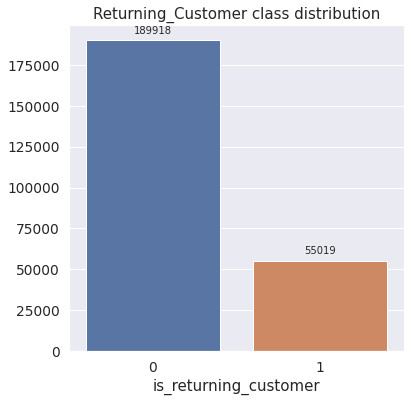

In [5]:
# Class Imbalance check with visualization

df_cls = df_order_label.copy() # create a copy for class-distribution calculation

df_cls_dist = df_cls["is_returning_customer"].value_counts()
df_cls_rpd = pd.DataFrame({'labels': df_cls_dist.index, 'values': df_cls_dist.values})
plt.figure(figsize = (6,6))
plt.title('Returning_Customer class distribution')
sns.set_color_codes("pastel")
splot = sns.barplot(x = 'labels', y="values", data=df_cls_rpd)
splot.set(xlabel='is_returning_customer', ylabel='', title='Returning_Customer class distribution')
for p in splot.patches:
    splot.annotate(int(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
locs, labels = plt.xticks()
plt.show()

In [6]:
# printing the first few records to define the structure of analysis

df_order_label.head()

,customer_id,is_returning_customer,first_order_before,last_order_before,cntns_order_period,comm_orderhour,num_success_order,num_fail_order,is_voucher,avg_voucher_amnt,is_deliveryfee,avg_deliveryfee,is_amount,avg_amount,num_restaurant,num_city,num_paymentid,num_platform,num_transmission,order_afternoon,order_early_morning,order_evening,order_late_night,order_morning,order_night,payment_id_1491,payment_id_1523,payment_id_1619,payment_id_1779,payment_id_1811,platform_id_525,platform_id_22167,platform_id_22263,platform_id_22295,platform_id_29463,platform_id_29495,platform_id_29751,platform_id_29815,platform_id_30135,platform_id_30199,platform_id_30231,platform_id_30359,platform_id_30391,platform_id_30423,transmission_id_212,transmission_id_1988,transmission_id_4196,transmission_id_4228,transmission_id_4260,transmission_id_4324,transmission_id_4356,transmission_id_4996,transmission_id_21124
0,000097eabfd9,0,620,620,1,19,1,0,0,0.0,0,0.000,1,11.46960,1,1,1,1,1,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0
1,0000e2c6d9be,0,397,397,1,20,1,0,0,0.0,0,0.000,1,9.55800,1,1,1,1,1,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0
2,000133bb597f,1,3,3,1,19,1,0,0,0.0,1,0.493,1,5.93658,1,1,1,1,1,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0
3,00018269939b,0,24,24,1,17,1,0,0,0.0,1,0.493,1,9.82350,1,1,1,1,1,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0
4,0001a00468a6,0,575,575,1,19,1,0,0,0.0,1,0.493,1,5.15070,1,1,1,1,1,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0


In [7]:
# Features

df_order_label.columns

Index(['customer_id', 'is_returning_customer', 'first_order_before',
       'last_order_before', 'cntns_order_period', 'comm_orderhour',
       'num_success_order', 'num_fail_order', 'is_voucher', 'avg_voucher_amnt',
       'is_deliveryfee', 'avg_deliveryfee', 'is_amount', 'avg_amount',
       'num_restaurant', 'num_city', 'num_paymentid', 'num_platform',
       'num_transmission', 'order_afternoon', 'order_early_morning',
       'order_evening', 'order_late_night', 'order_morning', 'order_night',
       'payment_id_1491', 'payment_id_1523', 'payment_id_1619',
       'payment_id_1779', 'payment_id_1811', 'platform_id_525',
       'platform_id_22167', 'platform_id_22263', 'platform_id_22295',
       'platform_id_29463', 'platform_id_29495', 'platform_id_29751',
       'platform_id_29815', 'platform_id_30135', 'platform_id_30199',
       'platform_id_30231', 'platform_id_30359', 'platform_id_30391',
       'platform_id_30423', 'transmission_id_212', 'transmission_id_1988',
       'transm

### 3.2 Bivariate Analysis

#### 3.2.1 **Continuous Variables**

1. First order is before how many days  
2. Last order is before how many days  
3. Customer's all orders fall between how many days  
4. Most common order_hour of Customers  
5. Number of successful orders    
6. Number of failed orders    
7. Average Voucher amount used   
8. Average Delivery fee paid   
9. Average amount paid   

In [8]:
# Create 2 different temporary dataframes for returning and non-returning customers

nonreturn_df = df_order_label.loc[df_order_label["is_returning_customer"]==0]
return_df = df_order_label.loc[df_order_label["is_returning_customer"]==1]
print(f'Number of Non-returning customers: {nonreturn_df.shape[0]},   Number of Returning customers: {return_df.shape[0]}')

Number of Non-returning customers: 189918,   Number of Returning customers: 55019


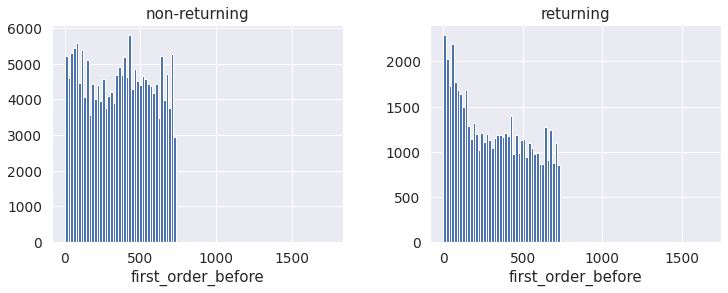

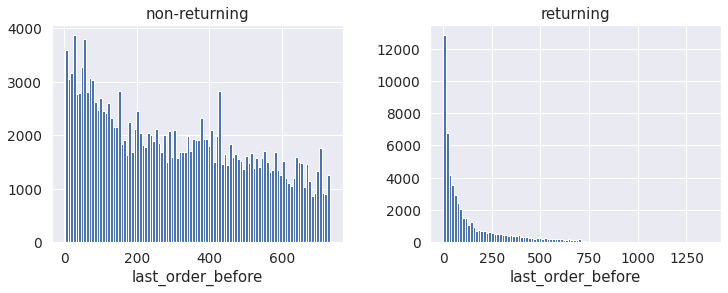

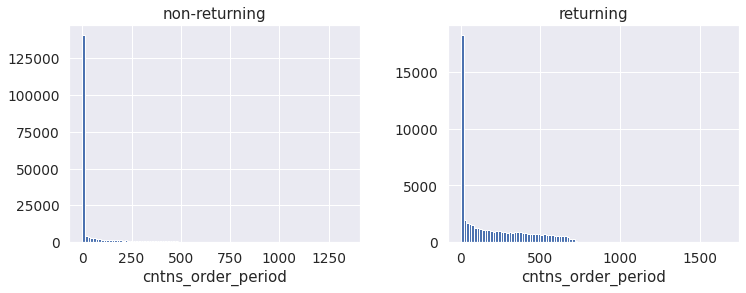

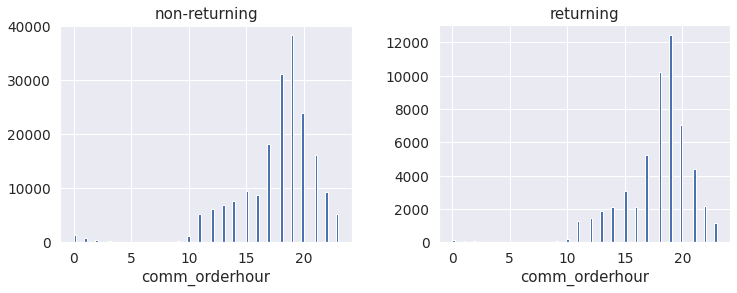

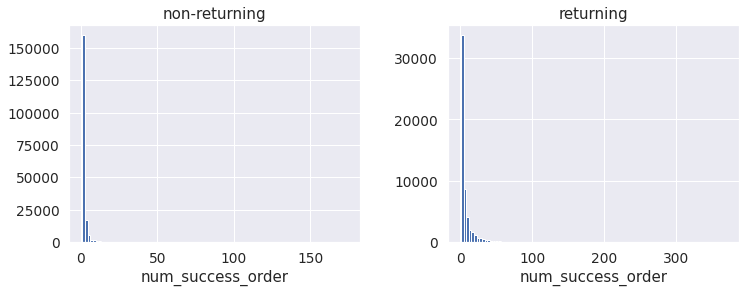

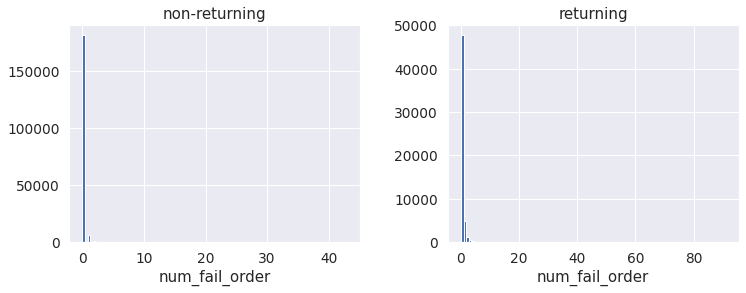

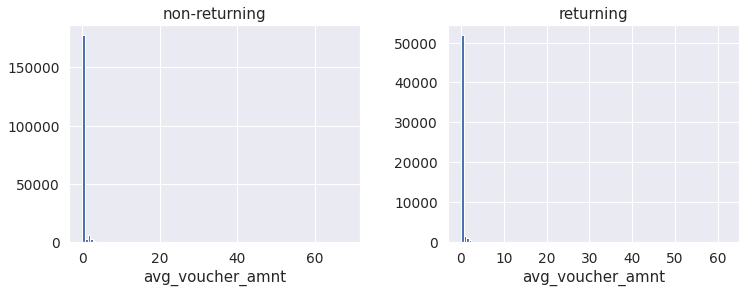

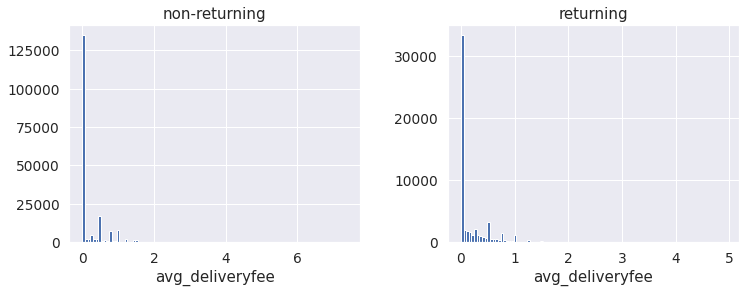

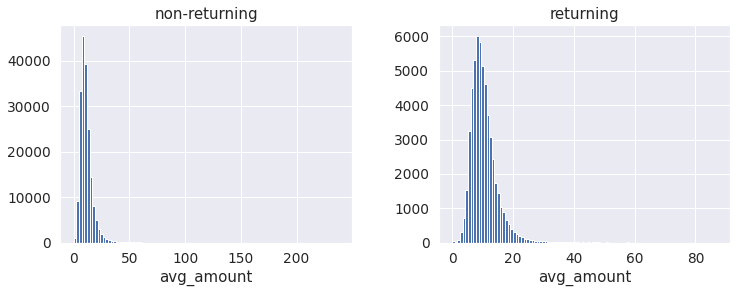

In [11]:
contns_vars = ["first_order_before", "last_order_before", "cntns_order_period", "comm_orderhour", 
               "num_success_order", "num_fail_order", "avg_voucher_amnt", "avg_deliveryfee", 
               "avg_amount"]

for var in contns_vars:
    bivar_contns(nonreturn_df, return_df, var)

* Significantly large difference between histograms of returning and non-returning customers for **last_order_before** feature

#### 3.2.2 **Multi-category categorical variables**

1. Returning Customer distribution based on **Number of unique restaurants ordered from**   
2. Returning Customer distribution based on **Number of unique cities ordered from**    
3. Returning Customer distribution based on **Number of unique payment_id used**    
4. Returning Customer distribution based on **Number of unique platform used**   
5. Returning Customer distribution based on **Number of unique transmission used**  

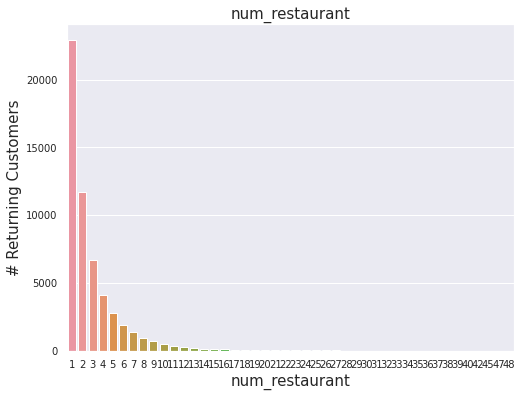

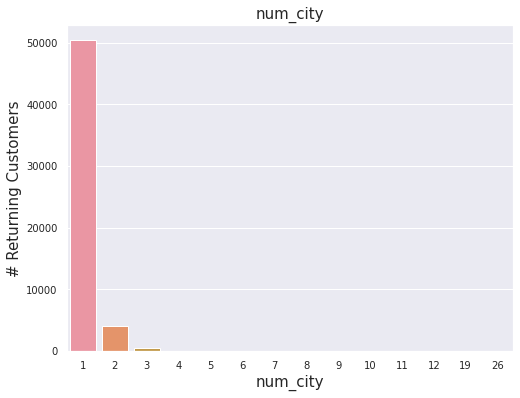

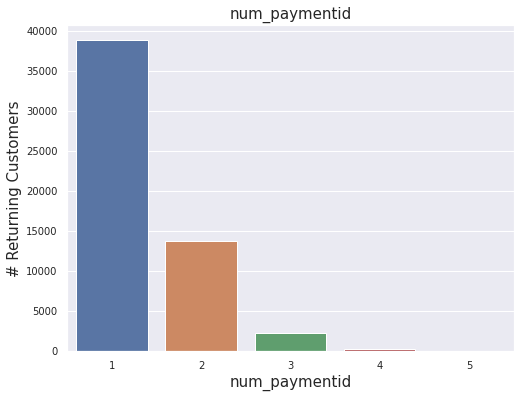

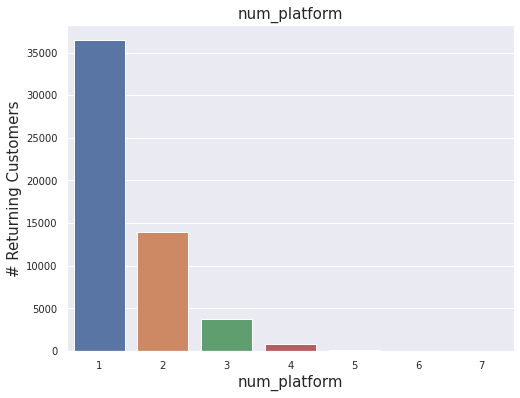

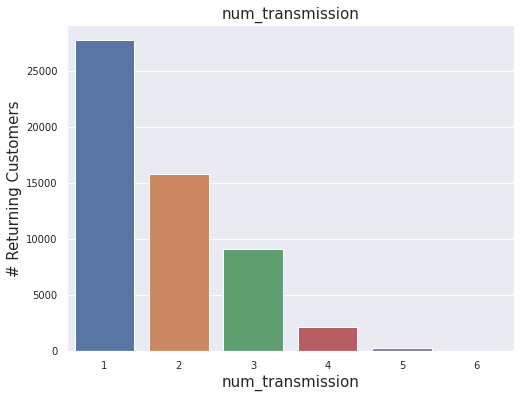

In [12]:
categorical_vars = [ "num_restaurant", "num_city", "num_paymentid", "num_platform", "num_transmission"]
target_var = "is_returning_customer"

for var in categorical_vars:
    bivar_multi_cat(return_df, var, target_var, label_rotation=False, horizontal_layout=True)


#### 3.2.3 **Binary categorical variables**

1. Returning Status vs **Voucher used or not**   
2. Returning Status vs **Delivery fee paid or not**    
3. Returning Status vs **Ever paid any amount or not**    

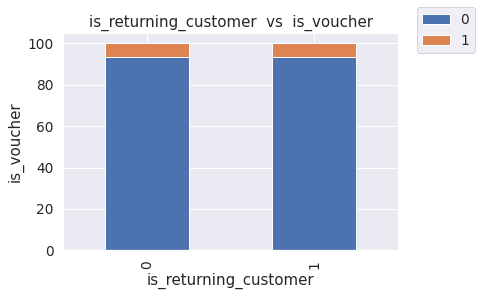

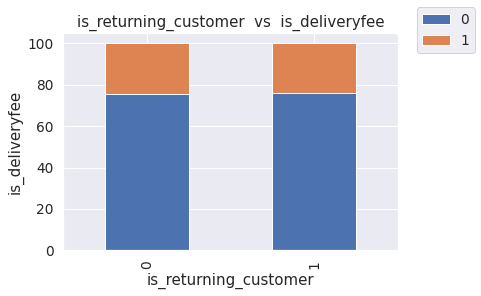

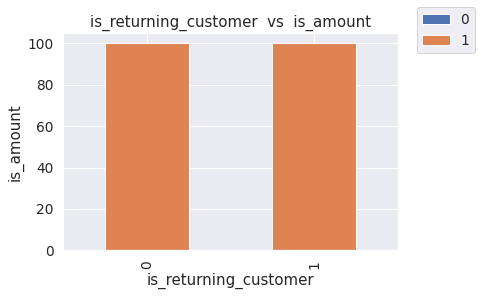

In [13]:
# For all the binary categorical variable plot the crosstab with target variable
binary_vars = ["is_voucher", "is_deliveryfee", "is_amount"]
target_var = "is_returning_customer"

for var in binary_vars:
    bivar_binary_cat(df_order_label, var, target_var)

* Can't see any significance difference in distribution for binary categorical features vs the target variable.
* Need to check, is there even a single customer present who has not paid any amount (May be due to fail order or fraud in payment or any such issues)

In [14]:
# 1. Check the number customers who has not paid ever
# 2. If any present, check the distribution of returning and non-returning customers 
print(df_order_label.loc[df_order_label["is_amount"]==0].shape[0])
df_order_label.loc[df_order_label["is_amount"]==0]["is_returning_customer"].value_counts()

583


0    502
1     81
Name: is_returning_customer, dtype: int64

* As 583 is a small number out of .24 million, couldn't recognize in the plot.
* Distributiopn of customer's returning status is similar as of overall data.

### 3.3 Multi-variate Analysis

**Will save it for future work**